In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import VariantCalling as vc
import numpy as np
import matplotlib.pyplot as plt

/Users/paopao_ch/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
img_row, img_col = 101, 178
nb_epoch = 50
batch_size = 16
nb_filters = 24
nb_conv = 5
nb_pool = 5

Progress:  0.0%% completed. 	Computing alignment 0 of 10
[0.5123461202031449, 0.20233548395731063, 0.2853183958395445]


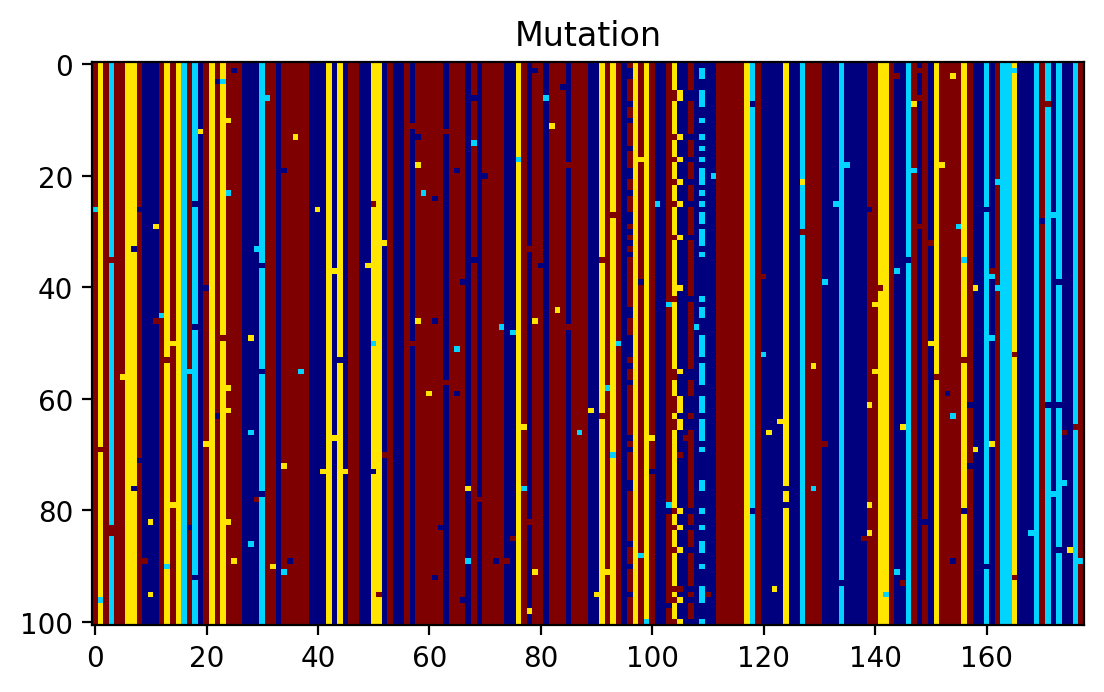

In [2]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData()
alignments, prob_lists = dg.simulate_clones(10,100,0.01,0.01)
alignments_int = dg.char_to_int(alignments)
alignment_int = dg.char_to_int(alignments[0])
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignment_int,cmap='jet')
print(prob_lists[0])

In [11]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData()
alignments, prob_lists = dg.simulate_clones(10000,100,0.01,0.01)
prob_lists = (np.array(prob_lists)*100).tolist()

Progress:  0.0%% completed. 	Computing alignment 0 of 10000
Progress:  4.0%% completed. 	Computing alignment 400 of 10000
Progress:  8.0%% completed. 	Computing alignment 800 of 10000
Progress:  12.0%% completed. 	Computing alignment 1200 of 10000
Progress:  16.0%% completed. 	Computing alignment 1600 of 10000
Progress:  20.0%% completed. 	Computing alignment 2000 of 10000
Progress:  24.0%% completed. 	Computing alignment 2400 of 10000
Progress:  28.0%% completed. 	Computing alignment 2800 of 10000
Progress:  32.0%% completed. 	Computing alignment 3200 of 10000
Progress:  36.0%% completed. 	Computing alignment 3600 of 10000
Progress:  40.0%% completed. 	Computing alignment 4000 of 10000
Progress:  44.0%% completed. 	Computing alignment 4400 of 10000
Progress:  48.0%% completed. 	Computing alignment 4800 of 10000
Progress:  52.0%% completed. 	Computing alignment 5200 of 10000
Progress:  56.0%% completed. 	Computing alignment 5600 of 10000
Progress:  60.0%% completed. 	Computing alignmen

In [12]:
print(len(alignments[0]))
alignments = [dg._array_dup(i,101) for i in alignments]
print(len(alignments))
print(alignments[8].shape)
print(alignments[8])
alignments = dg.char_to_int(alignments)

101
10000
(2, 101, 178)
[[['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ...
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']]

 [['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ...
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']]]


In [13]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(8000, 2, 101, 178)
(8000, 3)


In [28]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 6, 5)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
        self.drop1 = nn.Dropout(0.1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(16, 16, 5)
        self.pool3 = nn.MaxPool2d(4, 4)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(16, 16, 5)
        self.pool4 = nn.MaxPool2d(4, 4)

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(16 * 5 * 11, 120)  # not sure about dimensions
        self.drop2 = nn.Dropout(0.1)
        self.relu4 = nn.ReLU()

        self.fc2 = nn.Linear(120, 60)
        self.drop3 = nn.Dropout(0.1)
        self.relu5 = nn.ReLU()

        self.fc3 = nn.Linear(60, 3)
        self.soft = nn.Softmax()


    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.drop1(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.pool4(x)

        x = self.flat(x)

        x = self.fc1(x)
        x = self.drop2(x)
        x = self.relu4(x)

        x = self.fc2(x)
        x = self.drop3(x)
        x = self.relu5(x)

        x = self.fc3(x)
        x = self.soft(x)

        return x


In [29]:
def train(model, train_alignments, train_mutation_types, valid_alignments, valid_mutation_types, epochs=50, lr=0.001):
    crit = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_alignments).float(), torch.tensor(train_mutation_types))
    valid_dataset = torch.utils.data.TensorDataset(torch.from_numpy(valid_alignments).float(), torch.tensor(valid_mutation_types))
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=16)
    
    train_losses, valid_losses, valid_accs = [], [], []
    
    for epoch in range(1, epochs + 1):
        # train for 1 epoch
        model = model.train()
        epoch_loss, total = 0.0, 0
        for i, (batch_alignment, batch_mutation_type) in enumerate(train_loader):
            opt.zero_grad()
            out = model(batch_alignment)
            loss = crit(out, batch_mutation_type)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
            total += 1
        epoch_loss /= total
        
        # # compute validation loss and accuracy
        # model = model.eval()
        # valid_loss, n_correct, n, total = 0.0, 0, 0, 0
        # for i, (batch_alignment, batch_mutation_type) in enumerate(valid_loader):
        #     with torch.no_grad():
        #         out = model(batch_alignment)
        #         loss = crit(out, batch_mutation_type)
                
        #     valid_loss += loss.item()
        #     total += 1

        #     predict = torch.nn.functional.softmax(out, dim=1).argmax(dim=1)
        #     correct = predict == batch_mutation_type
        #     n += out.shape[0]
        #     n_correct += correct.sum()
        # valid_loss /= total
        # accuracy = n_correct / n
        
        train_losses.append(epoch_loss)
        # valid_losses.append(valid_loss)
        # valid_accs.append(accuracy)
        # print(f"epoch={epoch:2d}, train_loss={epoch_loss:.3f}, valid_loss={valid_loss:.3f}, accuracy={accuracy*100:.2f}%")
        print(f"epoch={epoch:2d}, train_loss={epoch_loss:.3f}")
        
    return train_losses, valid_losses, valid_accs

In [30]:
model = CNN()
n_epochs = 15 # number of epochs
lr = 0.001 # learning rate

In [31]:
train_losses, valid_losses, valid_accs = train(model, train_alignments, train_prob_lists, valid_alignments, valid_prob_lists, epochs=n_epochs, lr=lr)


RuntimeError: Given input size: (16x1x5). Calculated output size: (16x0x2). Output size is too small